# Analysis using the Data Model from Redshift

This notebook shows some examples of questions and SQL queries against the Redshift data model. 

In [5]:
import redshift_connector
import getpass
import awswrangler as wr
import matplotlib.pyplot as plt
import pandas as pd

### Step 1: Enter the Redshift Database Credentials. 
These will be the same credentials used in the Airflow UI to connect to the redshift cluster: 

In [2]:
print('Enter the redshift endpoint URL')
redshift_endpoint = getpass.getpass()
print('Enter the redshift username')
redshift_username = getpass.getpass()
print('Enter the redshift password')
redshift_password = getpass.getpass()
print('Enter the redshift port number')
redshift_port = getpass.getpass()
print("Enter the db name")
redshift_dbname = getpass.getpass()

Enter the redshift endpoint URL
········
Enter the redshift username
········
Enter the redshift password
········
Enter the redshift port number
········
Enter the db name
········


#Example Questions
1. How many users have contributed to Amphibian species observations each year?

In [45]:
#1. create a connection with redshift 
con = redshift_connector.connect(host=redshift_endpoint,
                                 database=redshift_dbname,
                                 user=redshift_username,
                                 password=redshift_password)

#2. run a SQL query
observers_by_year = wr.redshift.read_sql_query(
        sql = """
        select 
            count(distinct observer_id) as observers, 
            CAST(DATE_PART('year', observation_date) AS INTEGER) as year 
        from 
            production.species_observations
        group by 
            year""", 
        con=con)

#3. close the connection 
con.close()

# convert dataframe to a pandas dataframe 
observers_by_year = pd.DataFrame(observers_by_year)

In [49]:
observers_by_year = observers_by_year.sort_values('year')

Text(0.5, 1.0, 'Total Observers per Year')

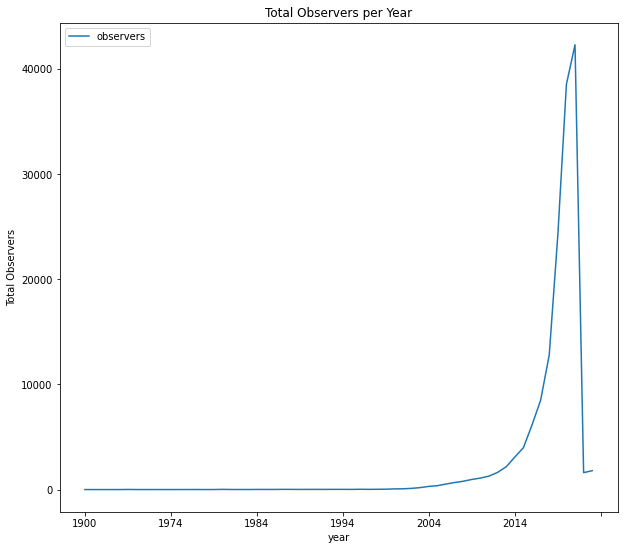

In [50]:
observers_by_year.plot(x="year", y="observers", kind="line", figsize=(10, 9))
plt.ylabel("Total Observers")
plt.title("Total Observers per Year")

2. Identify the top 5 Amphibian species that have the most iNaturalist observations outside of their known geospatial area/ habitat and are currently don't have an IUCN red list stats because they are classified as data deficient. 

In [40]:
#1. create a connection with redshift 
con = redshift_connector.connect(host=redshift_endpoint,
                                 database=redshift_dbname,
                                 user=redshift_username,
                                 password=redshift_password)

#2. run a SQL query
dd_species = wr.redshift.read_sql_query(
        sql = """
        with categories as (
            select 
                taxon_id, 
                iucn_category_id, 
                iucn_category_name 
            from 
                production.species_geospatial
            where 
                iucn_category_id ='DD'
            group by
                taxon_id, 
                iucn_category_id, 
                iucn_category_name)
        select 
            count(observation_uuid) as observations, 
            o.taxon_id, 
            t.taxon_name as species_name, 
            c.iucn_category_name
        from 
            production.species_observations o
            INNER JOIN 
                categories c ON 
                o.taxon_id = c.taxon_id
            INNER JOIN 
                production.taxa t ON 
                    t.taxon_id = o.taxon_id AND 
                    t.taxon_rank ='species' AND 
                    t.ancestry_id='20978'
        WHERE 
            o.quality_grade='research' AND 
            o.observed_in_known_area IS false
        GROUP BY 
            o.taxon_id, 
            t.taxon_name, 
            c.iucn_category_name
        order by observations desc
        limit 5""", 
        con=con)

#3. close the connection 
con.close()

# convert dataframe to a pandas dataframe 
dd_species = pd.DataFrame(dd_species)

In [41]:
dd_species

,observations,taxon_id,species_name,iucn_category_name
0,769,67107,Rhinella diptycha,data deficient
1,405,67089,Rhinella alata,data deficient
2,225,120791,Fejervarya multistriata,data deficient
3,165,66240,Odorrana graminea,data deficient
4,53,27111,Eurycea troglodytes,data deficient


3. Are there iNaturalist super users who are could be approached for future research efforts into the *Rhinella diptycha* species? 

In [43]:
#1. create a connection with redshift 
con = redshift_connector.connect(host=redshift_endpoint,
                                 database=redshift_dbname,
                                 user=redshift_username,
                                 password=redshift_password)

#2. run a SQL query
super_users = wr.redshift.read_sql_query(
        sql = """
        select 
            count(o.observation_uuid) as total_observations, 
            o.observer_id,
            ob.login_name,
            ob.observer_name
        from 
            production.species_observations o
            INNER JOIN production.observers ob on 
                o.observer_id = ob.observer_id
        where 
            o.taxon_id =67107
        group by 
            o.observer_id,
            ob.login_name,
            ob.observer_name
        order by 
            total_observations desc
        limit 5""", 
        con=con)

#3. close the connection 
con.close()

# convert dataframe to a pandas dataframe 
super_users = pd.DataFrame(super_users)

In [44]:
super_users

,total_observations,observer_id,login_name,observer_name
0,34,1205623,gussoni,Carlos Otávio Gussoni
1,19,19893,walterprado,Walter S. Prado
2,15,827979,douglas-u-oliveira,Douglas
3,15,1514402,hhulsberg,Hugo Hulsberg
4,14,186244,jocateme,João Menezes
